In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import community as community_louvain
from scipy.optimize import minimize


In [2]:
# Load and preprocess the stock data
df = pd.read_csv(r"C:\Gagan\University\Sem 5\Discrete Maths\Project\Graph-Theory-for-Portfolio-Optimization\ind_nifty500list.csv")
df['Symbol'] = df['Symbol'] + '.NS'

industry_abbr = {
    'Financial Services': 'FIN',
    'Diversified': 'DIV',
    'Capital Goods': 'CAP',
    'Construction Materials': 'CON',
    'Chemicals': 'CHE',
    'Healthcare': 'HEA',
    'Power': 'POW',
    'Metals & Mining': 'MET',
    'Services': 'SER',
    'Oil Gas & Consumable Fuels': 'OIL',
    'Fast Moving Consumer Goods': 'FMC',
    'Consumer Services': 'CSV',
    'Forest Materials': 'FOR',
    'Information Technology': 'IT',
    'Textiles': 'TEX',
    'Automobile and Auto Components': 'AUT',
    'Consumer Durables': 'CND',
    'Realty': 'REA',
    'Telecommunication': 'TEL',
    'Construction': 'CST',
    'Media Entertainment & Publication': 'MED'
}

df['Industry_Abbr'] = df['Industry'].map(industry_abbr)
df['Industry_Symbol_Abbr'] = df['Industry_Abbr'] + '_' + df['Symbol']

df

,Company Name,Industry,Symbol,Series,ISIN Code,Industry_Abbr,Industry_Symbol_Abbr
0,360 ONE WAM Ltd.,Financial Services,360ONE.NS,EQ,INE466L01038,FIN,FIN_360ONE.NS
1,3M India Ltd.,Diversified,3MINDIA.NS,EQ,INE470A01017,DIV,DIV_3MINDIA.NS
2,ABB India Ltd.,Capital Goods,ABB.NS,EQ,INE117A01022,CAP,CAP_ABB.NS
3,ACC Ltd.,Construction Materials,ACC.NS,EQ,INE012A01025,CON,CON_ACC.NS
4,AIA Engineering Ltd.,Capital Goods,AIAENG.NS,EQ,INE212H01026,CAP,CAP_AIAENG.NS
...,...,...,...,...,...,...,...
495,Zee Entertainment Enterprises Ltd.,Media Entertainment & Publication,ZEEL.NS,EQ,INE256A01028,MED,MED_ZEEL.NS
496,Zensar Technolgies Ltd.,Information Technology,ZENSARTECH.NS,EQ,INE520A01027,IT,IT_ZENSARTECH.NS
497,Zomato Ltd.,Consumer Services,ZOMATO.NS,EQ,INE758T01015,CSV,CSV_ZOMATO.NS
498,Zydus Lifesciences Ltd.,Healthcare,ZYDUSLIFE.NS,EQ,INE010B01027,HEA,HEA_ZYDUSLIFE.NS


In [3]:
# Download stock data
tickers = df['Symbol'].to_list()
data = yf.download(tickers, start="2014-04-01", end="2024-03-31")["Close"]
data.index = pd.to_datetime(data.index).strftime('%Y-%m-%d')

symbol_abbr = pd.Series(df.Industry_Symbol_Abbr.values, index=df.Symbol).to_dict()
data.rename(columns=symbol_abbr, inplace=True)
sector_sorted_columns = sorted(data.columns, key=lambda x: x.split('_')[0])
data = data[sector_sorted_columns]

data

[*********************100%***********************]  500 of 500 completed

9 Failed downloads:
['GODIGIT.NS', 'AADHARHFC.NS', 'AEGISLOG.NS', 'UNITDSPR.NS', 'BHARTIHEXA.NS', 'EMCURE.NS', 'INDGN.NS', 'TBOTEK.NS']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2014-04-01 -> 2024-03-31) (Yahoo error = "Data doesn\'t exist for startDate = 1396290600, endDate = 1711823400")')
['TV18BRDCST.NS']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2014-04-01 -> 2024-03-31)')


Ticker,AUT_APOLLOTYRE.NS,AUT_ARE&M.NS,AUT_ASAHIINDIA.NS,AUT_BAJAJ-AUTO.NS,AUT_BALKRISIND.NS,AUT_BHARATFORG.NS,AUT_BOSCHLTD.NS,AUT_CEATLTD.NS,AUT_CIEINDIA.NS,AUT_CRAFTSMAN.NS,...,TEL_ROUTE.NS,TEL_TATACOMM.NS,TEL_TEJASNET.NS,TEL_TTML.NS,TEX_ALOKINDS.NS,TEX_KPRMILL.NS,TEX_PAGEIND.NS,TEX_TRIDENT.NS,TEX_VTL.NS,TEX_WELSPUNLIV.NS
Date,,,,,,,,,,,,,,,,,,,,,
2014-04-01,162.300003,NaN,58.099998,2065.199951,242.332764,208.675003,10767.099609,439.600006,77.500000,NaN,...,NaN,187.418579,NaN,6.985024,6.700000,11.795000,6365.100098,1.480000,71.199997,10.380000
2014-04-02,163.100006,NaN,58.750000,2053.600098,248.232529,215.199997,10641.650391,433.750000,79.400002,NaN,...,NaN,187.542770,NaN,7.224237,7.600000,11.610000,6230.149902,1.515000,70.730003,10.280000
2014-04-03,166.899994,NaN,59.000000,2053.350098,247.667130,211.574997,10619.549805,415.450012,80.349998,NaN,...,NaN,187.511719,NaN,6.985024,7.600000,11.400000,6117.700195,1.510000,69.900002,10.215000
2014-04-04,167.100006,NaN,58.849998,2028.900024,244.422256,212.699997,10226.849609,393.700012,81.500000,NaN,...,NaN,187.915298,NaN,7.272080,7.800000,11.405000,5938.649902,1.570000,68.400002,10.195000
2014-04-07,166.000000,NaN,61.549999,2022.599976,241.079071,218.425003,10368.549805,398.450012,81.800003,NaN,...,NaN,181.551086,NaN,7.128552,7.900000,11.905000,5705.299805,1.565000,69.190002,10.150000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-21,461.000000,756.150024,520.450012,8750.599609,2309.550049,1102.000000,30066.250000,2528.149902,441.649994,3972.350098,...,1603.449951,1908.199951,692.750000,78.250000,27.049999,801.200012,34092.851562,37.000000,433.049988,141.350006
2024-03-22,468.350006,778.000000,530.799988,8945.250000,2276.050049,1128.949951,30178.699219,2593.000000,445.549988,4149.549805,...,1600.550049,1922.650024,687.000000,78.550003,27.350000,794.000000,34449.851562,38.650002,439.299988,141.649994
2024-03-26,471.450012,774.200012,528.799988,8960.549805,2266.399902,1130.150024,30680.349609,2626.800049,445.100006,4172.049805,...,1600.500000,1947.599976,673.000000,76.650002,26.650000,826.250000,34609.500000,37.400002,441.399994,140.550003


In [4]:
# Remove stocks with more than two consecutive NaNs
def remove_stocks_with_consecutive_nans(data, max_consecutive_nans=2):
    nan_mask = data.isna()
    columns_to_drop = [col for col in nan_mask.columns if nan_mask[col].astype(int).groupby((~nan_mask[col]).cumsum()).cumsum().max() > max_consecutive_nans]
    data = data.drop(columns=columns_to_drop)
    return data

data = remove_stocks_with_consecutive_nans(data)
data

Ticker,AUT_APOLLOTYRE.NS,AUT_ASAHIINDIA.NS,AUT_BAJAJ-AUTO.NS,AUT_BALKRISIND.NS,AUT_BHARATFORG.NS,AUT_BOSCHLTD.NS,AUT_CEATLTD.NS,AUT_CIEINDIA.NS,AUT_EICHERMOT.NS,AUT_EXIDEIND.NS,...,TEL_INDUSTOWER.NS,TEL_ITI.NS,TEL_TATACOMM.NS,TEL_TTML.NS,TEX_ALOKINDS.NS,TEX_KPRMILL.NS,TEX_PAGEIND.NS,TEX_TRIDENT.NS,TEX_VTL.NS,TEX_WELSPUNLIV.NS
Date,,,,,,,,,,,,,,,,,,,,,
2014-04-01,162.300003,58.099998,2065.199951,242.332764,208.675003,10767.099609,439.600006,77.500000,604.945007,122.300003,...,203.750000,16.150000,187.418579,6.985024,6.700000,11.795000,6365.100098,1.480000,71.199997,10.380000
2014-04-02,163.100006,58.750000,2053.600098,248.232529,215.199997,10641.650391,433.750000,79.400002,613.585022,124.849998,...,203.050003,16.400000,187.542770,7.224237,7.600000,11.610000,6230.149902,1.515000,70.730003,10.280000
2014-04-03,166.899994,59.000000,2053.350098,247.667130,211.574997,10619.549805,415.450012,80.349998,615.474976,124.099998,...,199.100006,16.150000,187.511719,6.985024,7.600000,11.400000,6117.700195,1.510000,69.900002,10.215000
2014-04-04,167.100006,58.849998,2028.900024,244.422256,212.699997,10226.849609,393.700012,81.500000,604.974976,122.900002,...,199.800003,16.450001,187.915298,7.272080,7.800000,11.405000,5938.649902,1.570000,68.400002,10.195000
2014-04-07,166.000000,61.549999,2022.599976,241.079071,218.425003,10368.549805,398.450012,81.800003,604.325012,124.449997,...,200.250000,16.299999,181.551086,7.128552,7.900000,11.905000,5705.299805,1.565000,69.190002,10.150000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-21,461.000000,520.450012,8750.599609,2309.550049,1102.000000,30066.250000,2528.149902,441.649994,3918.949951,305.799988,...,250.199997,256.100006,1908.199951,78.250000,27.049999,801.200012,34092.851562,37.000000,433.049988,141.350006
2024-03-22,468.350006,530.799988,8945.250000,2276.050049,1128.949951,30178.699219,2593.000000,445.549988,3988.399902,307.200012,...,271.299988,261.000000,1922.650024,78.550003,27.350000,794.000000,34449.851562,38.650002,439.299988,141.649994
2024-03-26,471.450012,528.799988,8960.549805,2266.399902,1130.150024,30680.349609,2626.800049,445.100006,3911.100098,304.549988,...,283.649994,252.649994,1947.599976,76.650002,26.650000,826.250000,34609.500000,37.400002,441.399994,140.550003


In [5]:
# Calculate log returns
log_returns = np.log(data / data.shift(1))
log_returns = log_returns.dropna(axis=1, how='all')
log_returns = log_returns.drop(log_returns.index[0])
log_returns

Ticker,AUT_APOLLOTYRE.NS,AUT_ASAHIINDIA.NS,AUT_BAJAJ-AUTO.NS,AUT_BALKRISIND.NS,AUT_BHARATFORG.NS,AUT_BOSCHLTD.NS,AUT_CEATLTD.NS,AUT_CIEINDIA.NS,AUT_EICHERMOT.NS,AUT_EXIDEIND.NS,...,TEL_INDUSTOWER.NS,TEL_ITI.NS,TEL_TATACOMM.NS,TEL_TTML.NS,TEX_ALOKINDS.NS,TEX_KPRMILL.NS,TEX_PAGEIND.NS,TEX_TRIDENT.NS,TEX_VTL.NS,TEX_WELSPUNLIV.NS
Date,,,,,,,,,,,,,,,,,,,,,
2014-04-02,0.004917,0.011126,-0.005633,0.024054,0.030790,-0.011720,-0.013397,0.024220,0.014181,0.020636,...,-0.003441,0.015361,0.000662,0.033673,0.126041,-0.015809,-0.021430,0.023373,-0.006623,-0.009681
2014-04-03,0.023031,0.004246,-0.000122,-0.002280,-0.016988,-0.002079,-0.043106,0.011894,0.003075,-0.006025,...,-0.019645,-0.015361,-0.000166,-0.033673,0.000000,-0.018253,-0.018214,-0.003306,-0.011804,-0.006343
2014-04-04,0.001198,-0.002546,-0.011979,-0.013188,0.005303,-0.037680,-0.053773,0.014211,-0.017207,-0.009717,...,0.003510,0.018405,0.002150,0.040274,0.025976,0.000439,-0.029704,0.038966,-0.021693,-0.001960
2014-04-07,-0.006605,0.044858,-0.003110,-0.013772,0.026560,0.013761,0.011993,0.003674,-0.001075,0.012533,...,0.002250,-0.009160,-0.034454,-0.019934,0.012739,0.042907,-0.040086,-0.003190,0.011484,-0.004424
2014-04-09,0.011679,0.010505,0.004292,0.004070,0.013528,-0.000275,0.014451,0.182220,0.028056,0.006008,...,-0.021707,0.018238,0.006307,0.033006,0.037271,0.054355,-0.002193,-0.066031,-0.000289,0.014185
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-21,0.019605,0.017933,0.013229,0.012702,0.008475,0.006535,0.022642,0.017588,0.011639,0.014327,...,-0.001996,0.029924,0.010483,0.001919,0.016776,0.013825,0.025519,0.017724,0.015241,0.001770
2024-03-22,0.015818,0.019691,0.022000,-0.014611,0.024161,0.003733,0.025328,0.008792,0.017566,0.004568,...,0.080965,0.018952,0.007544,0.003827,0.011030,-0.009027,0.010417,0.043629,0.014329,0.002120
2024-03-26,0.006597,-0.003775,0.001709,-0.004249,0.001062,0.016486,0.012951,-0.001010,-0.019571,-0.008664,...,0.044516,-0.032515,0.012893,-0.024486,-0.025927,0.039814,0.004624,-0.032876,0.004769,-0.007796


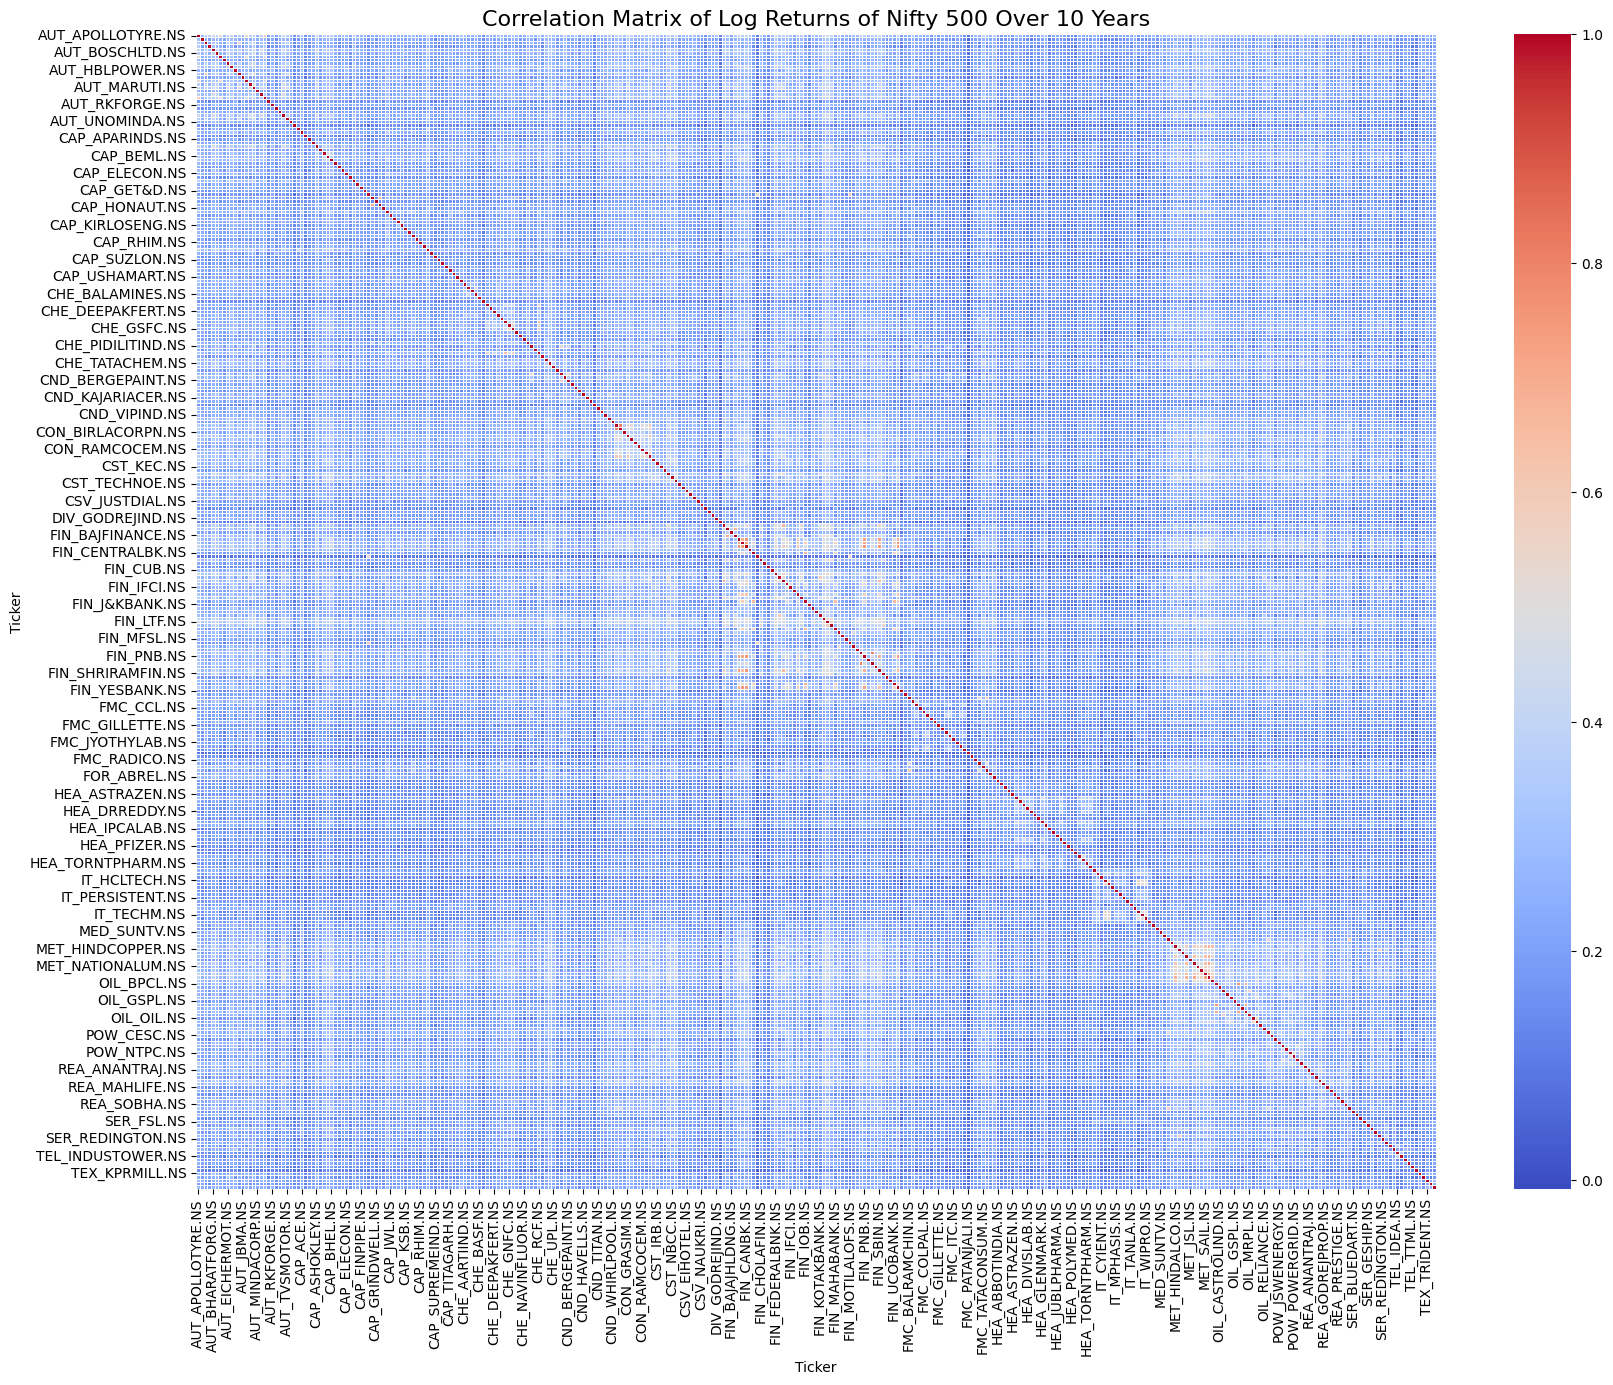

In [6]:
# Calculate the correlation matrix
correlation_matrix = log_returns.corr()

# Plot the correlation matrix
plt.figure(figsize=(20, 15))
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=False, linewidths=0.5)
plt.title("Correlation Matrix of Log Returns of Nifty 500 Over 10 Years", fontsize=16)
# plt.savefig('Correlation Matrix of Log Returns of Nifty 500 Over 5 Years.png')
plt.show()

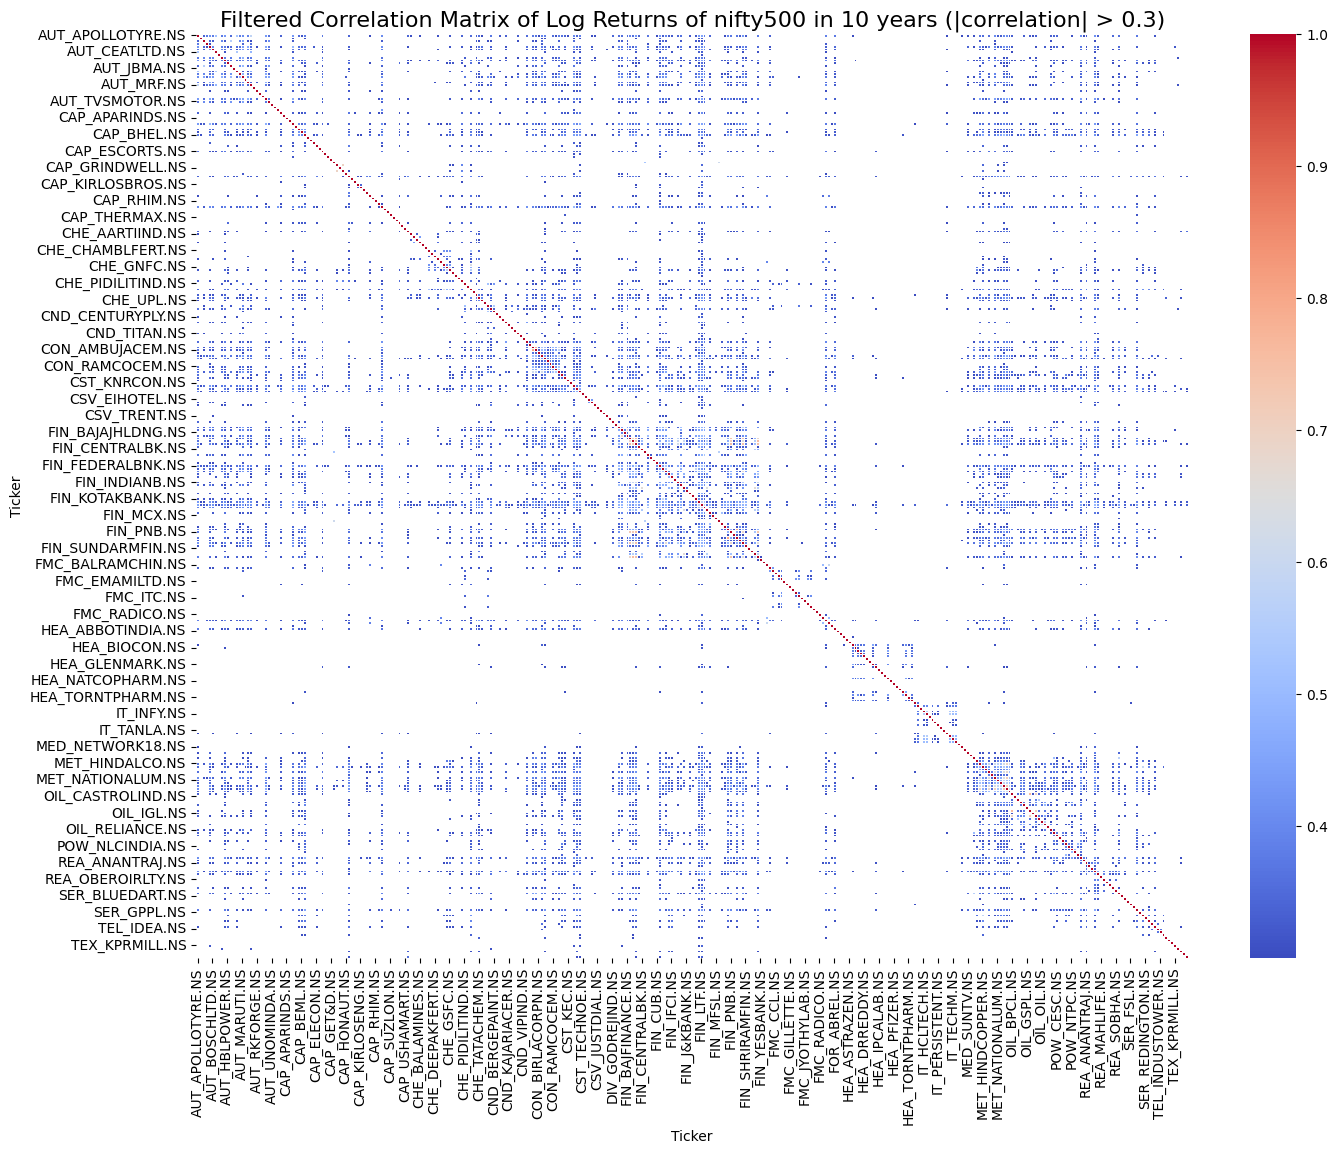

In [7]:
# Only display correlations with absolute values above threshold
threshold = 0.3
filtered_correlation = correlation_matrix[(correlation_matrix >= threshold) | (correlation_matrix <= -threshold)]

plt.figure(figsize=(16,12))
sns.heatmap(filtered_correlation, cmap='coolwarm', annot=False, linewidths=0.5)
plt.title("Filtered Correlation Matrix of Log Returns of nifty500 in 10 years (|correlation| > 0.3)", fontsize=16)
# plt.savefig('Filtered Correlation Matrix of Log Returns of nifty500 in 10 years.png')
plt.show()

In [8]:
# Construct the graph using correlation threshold
G = nx.Graph()

for ticker in correlation_matrix.columns:
    G.add_node(ticker)

for i, stock1 in enumerate(correlation_matrix.columns):
    for j, stock2 in enumerate(correlation_matrix.columns):
        if i < j:
            corr_value = correlation_matrix.loc[stock1, stock2]
            if abs(corr_value) >= threshold:
                G.add_edge(stock1, stock2, weight=corr_value)

In [9]:
# Apply Louvain method for community detection
partition = community_louvain.best_partition(G, weight='weight')

# Create clusters dictionary
clusters = {}
for node, cluster_id in partition.items():
    if cluster_id not in clusters:
        clusters[cluster_id] = []
    clusters[cluster_id].append(node)

In [10]:
# Calculate centrality of each stock
centrality = nx.degree_centrality(G)
selected_stocks = []

# Select top central stocks from each cluster
for cluster_id, stocks in clusters.items():
    cluster_centrality = {stock: centrality[stock] for stock in stocks}
    top_stocks = sorted(cluster_centrality, key=cluster_centrality.get, reverse=True)[:max(1, len(stocks)//5)]
    selected_stocks.extend(top_stocks)

# Filter log returns for selected stocks
selected_log_returns = log_returns[selected_stocks]

In [11]:
# Calculate expected returns and volatility
stock_returns = selected_log_returns.mean() * 252
stock_volatility = selected_log_returns.std() * np.sqrt(252)

# Construct weights based on the inverse of volatility (risk parity)
inv_volatility = 1 / stock_volatility
weights = inv_volatility / inv_volatility.sum()

# Portfolio returns
portfolio_returns = selected_log_returns.dot(weights)
cumulative_portfolio_returns = (1 + portfolio_returns).cumprod()

In [12]:
# Portfolio optimization with minimum allocation constraint
def portfolio_annualized_performance(weights, log_returns):
    portfolio_return = np.sum(weights * log_returns.mean()) * 252
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(log_returns.cov() * 252, weights)))
    return portfolio_return, portfolio_volatility

def negative_sharpe_ratio(weights, log_returns):
    p_return, p_volatility = portfolio_annualized_performance(weights, log_returns)
    return -p_return / p_volatility

# Minimum allocation constraint (e.g., 0.1%)
min_allocation = 0.001

# Constraints to ensure portfolio weights sum to 1 and no stock is below the minimum allocation
constraints = [
    {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1},  # Sum of weights must be 1
    {'type': 'ineq', 'fun': lambda weights: weights - min_allocation}  # Each weight must be at least 0.1%
]

# Bounds for each stock's weight
bounds = tuple((min_allocation, 1) for _ in range(len(selected_stocks)))
initial_weights = np.ones(len(selected_stocks)) / len(selected_stocks)

# Optimize portfolio using SLSQP
optimized_results = minimize(
    negative_sharpe_ratio,
    initial_weights,
    args=(selected_log_returns,),
    method='SLSQP',
    bounds=bounds,
    constraints=constraints
)

optimized_weights = optimized_results.x

# Normalize weights to ensure the sum is exactly 1
optimized_weights /= optimized_weights.sum()


In [13]:
# Prepare a dataframe for visualization
portfolio_weights_df = pd.DataFrame({
    'Stock': selected_stocks,
    'Weight': optimized_weights
})


# Calculate the percentage allocation
portfolio_weights_df['Percentage Allocation'] = portfolio_weights_df['Weight'] * 100

# Display the percentage allocation of each stock in the portfolio
print("Portfolio Component Percentage Allocation:")
final = portfolio_weights_df.sort_values(by='Percentage Allocation', ascending=False)
print(final)

Portfolio Component Percentage Allocation:
                 Stock    Weight  Percentage Allocation
64    CHE_SOLARINDS.NS  0.152397              15.239704
84   HEA_ABBOTINDIA.NS  0.135264              13.526416
48    CAP_APLAPOLLO.NS  0.060252               6.025224
44     AUT_UNOMINDA.NS  0.057413               5.741303
42      AUT_OLECTRA.NS  0.054778               5.477791
..                 ...       ...                    ...
7    FMC_TATACONSUM.NS  0.001000               0.100000
32     CHE_TATACHEM.NS  0.001000               0.100000
90       HEA_FORTIS.NS  0.001000               0.100000
3        CON_GRASIM.NS  0.001000               0.100000
107         OIL_IOC.NS  0.001000               0.100000

[118 rows x 3 columns]


In [14]:
final.to_csv('final.csv')

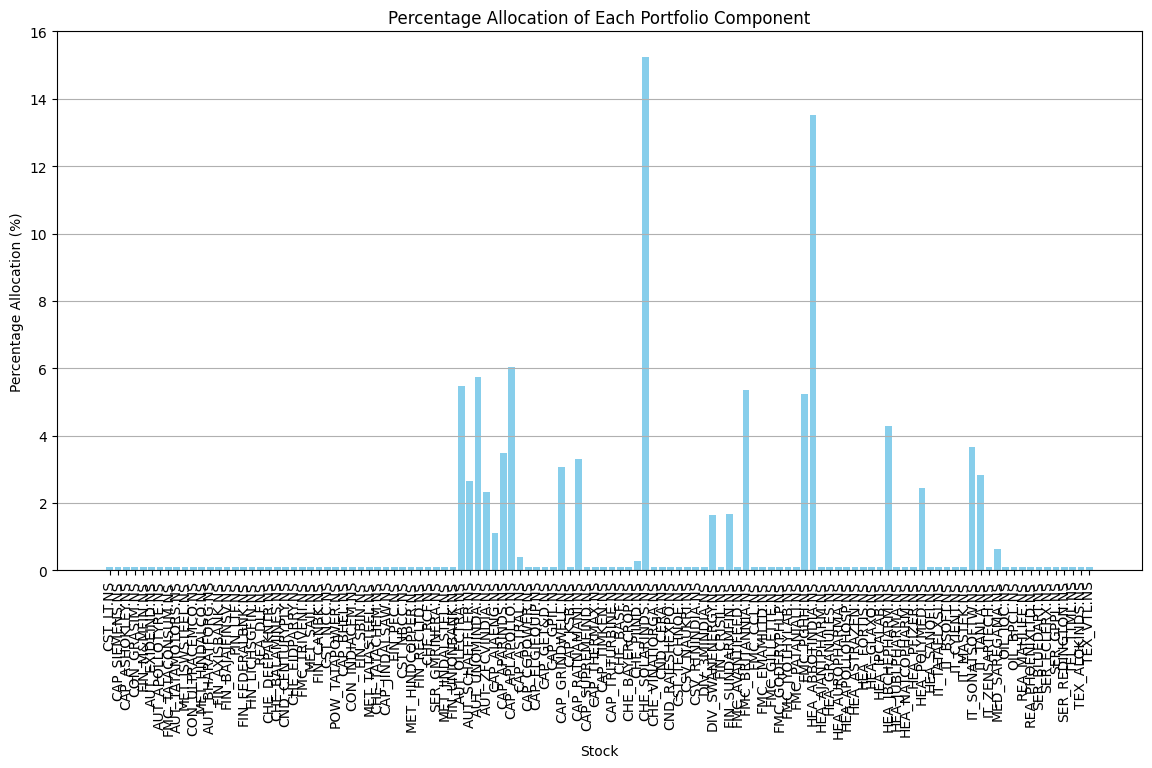

In [15]:
# Plot the percentage allocation as a bar chart
plt.figure(figsize=(14, 7))
plt.bar(portfolio_weights_df['Stock'], portfolio_weights_df['Percentage Allocation'], color='skyblue')
plt.xlabel("Stock")
plt.ylabel("Percentage Allocation (%)")
plt.title("Percentage Allocation of Each Portfolio Component")
plt.xticks(rotation=90)
plt.grid(axis='y')
plt.show()

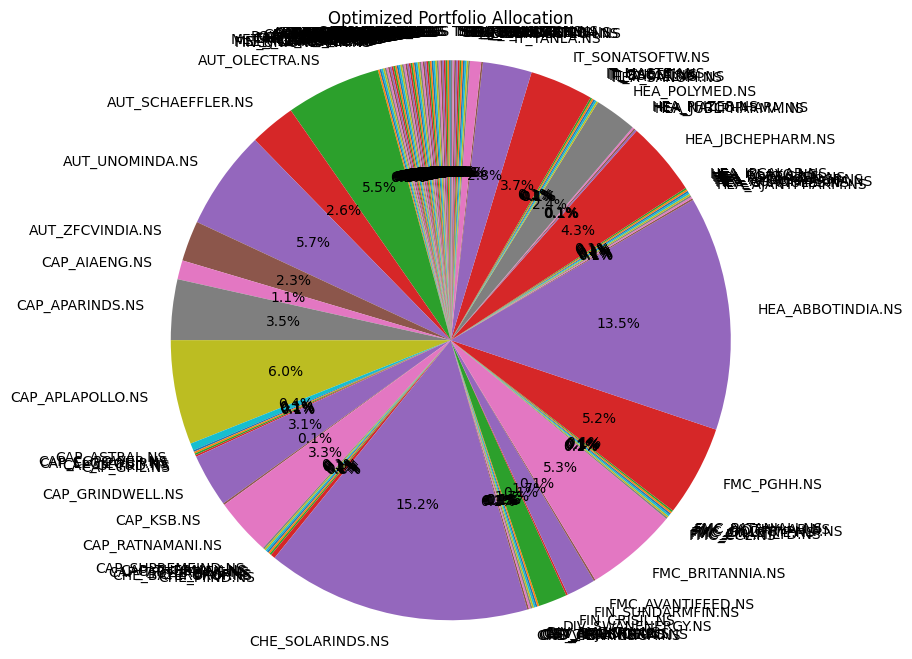

In [16]:
# Plot portfolio allocation
plt.figure(figsize=(10, 8))
plt.pie(portfolio_weights_df['Weight'], labels=portfolio_weights_df['Stock'], autopct='%1.1f%%', startangle=90)
plt.title("Optimized Portfolio Allocation")
plt.axis('equal')  # Equal aspect ratio ensures the pie chart is a circle.
plt.show()

[*********************100%***********************]  1 of 1 completed


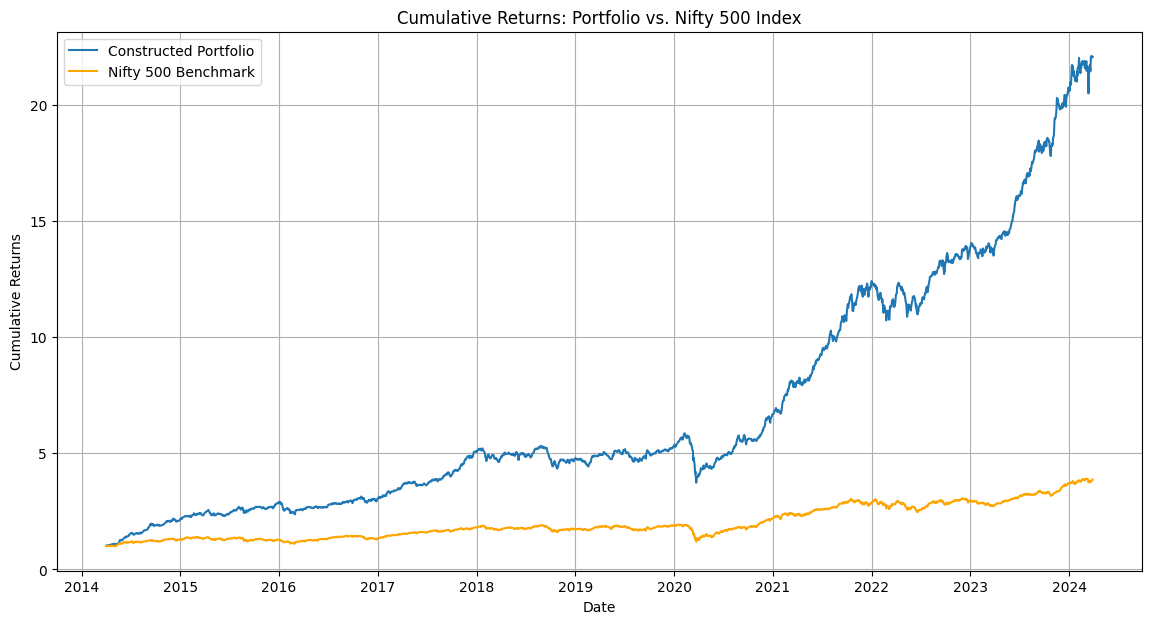

In [17]:
# Calculate portfolio returns
portfolio_returns = selected_log_returns.dot(optimized_weights)
cumulative_portfolio_returns = (1 + portfolio_returns).cumprod()

# Benchmark (Nifty 500) returns
benchmark = yf.download("^CRSLDX", start="2014-04-01", end="2024-03-31")["Close"].pct_change().dropna()
cumulative_benchmark_returns = (1 + benchmark).cumprod()

# Ensure the index of cumulative returns are datetime objects
cumulative_portfolio_returns.index = pd.to_datetime(cumulative_portfolio_returns.index)
cumulative_benchmark_returns.index = pd.to_datetime(cumulative_benchmark_returns.index)

# Plot cumulative returns
plt.figure(figsize=(14, 7))
plt.plot(cumulative_portfolio_returns, label="Constructed Portfolio")
plt.plot(cumulative_benchmark_returns, label="Nifty 500 Benchmark", color='orange')
plt.title("Cumulative Returns: Portfolio vs. Nifty 500 Index")
plt.xlabel("Date")
plt.ylabel("Cumulative Returns")
plt.legend()
plt.grid(True)
plt.show()

In [18]:
# Portfolio performance metrics
annualized_return = portfolio_returns.mean() * 252
annualized_volatility = portfolio_returns.std() * np.sqrt(252)
sharpe_ratio = annualized_return / annualized_volatility

print("Portfolio Performance Metrics:")
print(f"Annualized Return: {annualized_return:.2%}")
print(f"Annualized Volatility: {annualized_volatility:.2%}")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")

# Benchmark performance metrics
benchmark_annualized_return = benchmark.mean() * 252
benchmark_annualized_volatility = benchmark.std() * np.sqrt(252)
benchmark_sharpe_ratio = benchmark_annualized_return / benchmark_annualized_volatility

print("\nBenchmark Performance Metrics:")
print(f"Annualized Return: {benchmark_annualized_return:.2%}")
print(f"Annualized Volatility: {benchmark_annualized_volatility:.2%}")
print(f"Sharpe Ratio: {benchmark_sharpe_ratio:.2f}")

Portfolio Performance Metrics:
Annualized Return: 32.92%
Annualized Volatility: 15.66%
Sharpe Ratio: 2.10

Benchmark Performance Metrics:
Annualized Return: 15.25%
Annualized Volatility: 16.34%
Sharpe Ratio: 0.93
